In [1]:
!pip install git+https://github.com/kunguz/odak.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/kunguz/odak.git to /tmp/pip-req-build-2yplqkwk
  Running command git clone -q https://github.com/kunguz/odak.git /tmp/pip-req-build-2yplqkwk
     |████████████████████████████████| 3.1 MB 22.8 MB/s 
  Created wheel for odak: filename=odak-0.2.1-py3-none-any.whl size=116476 sha256=4d340f9a3e67787e40a2a4fd7b201f7650acaa88d43d9134f61aa005ef955f32
  Stored in directory: /tmp/pip-ephem-wheel-cache-wsc58efs/wheels/5b/1f/1a/1d2de547c1d893422b054c9aea06da6ce4efbf401114444959
Successfully built odak
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2

In [2]:
import odak
import torch 
import numpy as np 
import sys
import odak.learn.raytracing as ODL
import matplotlib.pyplot as plt
import math
import odak.raytracing as raytracer
import odak.tools as tools
import odak.raytracing as raytracer
from odak.raytracing.ray import create_ray
import cv2
import sys

In [3]:
device = torch.device('cuda')

In [4]:
import sys
class aperture_array():

  def __init__(self, device):
    self.device = device
    self.init_light_sources()
    self.init_aperture_array()
    self.init_detector()
  
  def init_light_sources(self, dimensions=[0.01, 0.015], pixel_count=[20, 30], Z=0.):
      x = torch.linspace(-dimensions[0]/2., dimensions[0]/2., pixel_count[0])
      y = torch.linspace(-dimensions[1]/2., dimensions[1]/2., pixel_count[1])
      X, Y = torch.meshgrid(x, y, indexing='ij')
      self.light_source_locations = torch.zeros(X.shape[0], X.shape[1], 3).to(self.device)
      self.light_source_locations[:, :, 0] = X
      self.light_source_locations[:, :, 1] = Y
      self.light_source_locations[:, :, 2] = Z
      
      
  def init_aperture_array(self, dimensions=[0.01, 0.015], pixel_count=[20, 30], Z=0.01):
        x = torch.linspace(-dimensions[0]/2., dimensions[0]/2., pixel_count[0])
        y = torch.linspace(-dimensions[1]/2., dimensions[1]/2., pixel_count[1])
        X, Y = torch.meshgrid(x, y, indexing='ij')
        self.aperture_array_locations = torch.zeros(X.shape[0], X.shape[1], 3).to(self.device)
        self.aperture_array_locations[:, :, 0] = X
        self.aperture_array_locations[:, :, 1] = Y
        self.aperture_array_locations[:, :, 2] = Z
        self.aperture_array = torch.rand(X.shape[0], X.shape[1], requires_grad=True).to(self.device) # makes it differentiable
        
  def init_detector(self, dimensions=[0.01, 0.015], pixel_count=[20, 30], Z=0.05):
        points = torch.tensor([0., 0, Z]).to(self.device)
        self.detector_surface = odak.learn.raytracing.define_plane(points)
        # Locations of my pixels on my detector could be defined here.
        
  def intersection_points_to_image(self, points, amplitudes):
        # Intersection points and paint an image on a detector?

        self.focal_length= torch.tensor([0.05,0.05])
        
        # Creating the pinhole intrinsic matrix
        camera_Intrinsic= torch.tensor([[self.focal_length[0], 0., 0., 0.],
                           [0.,self.focal_length[1], 0., 0.], 
                           [0., 0., 1., 0.]]).to(self.device)

        one=torch.tensor([1]).to(self.device)
        coordinates= []
        for i in points: 
          # making the points a 4 x 1 matrix
          new_points= torch.hstack((i, one)).view(4, 1)
          cam_cood = torch.matmul(camera_Intrinsic, new_points)
          # camera coordinates
          result = cam_cood[:-1]
          coordinates.append(result)

      

        new_coords= torch.stack(coordinates).to(self.device)
        new_coords=  new_coords.squeeze()

        # this gives the coordinates on the 2D image plane
        
        #new_coords=new_coords.view(20,30, 2)
        
        detector= torch.zeros((600, 3)).to(self.device)
        for i in new_coords: 
         
            #giving the indexed parts a value of 1 to make it visible
            detector[i[0].long(), i[1].long()] = 1.

        
        return detector
  
  def forward(self):
        light_source_locations = self.light_source_locations.view(-1, 3)
        aperture_array_locations = self.aperture_array_locations.view(-1, 3)

        aperture_array = self.aperture_array.view(-1, 3)
        #print(aperture_array.shape)
        for light_source_location in light_source_locations:
            rays_from_light_source = odak.learn.raytracing.create_ray_from_two_points(light_source_location, aperture_array_locations)
            intersection_normals_w_detector, _ = odak.learn.raytracing.intersect_w_surface(rays_from_light_source, self.detector_surface)
            intersection_points_w_detector = intersection_normals_w_detector[:, 0]
            detector_image = self.intersection_points_to_image(
                                                                intersection_points_w_detector,
                                                                aperture_array
                                                              )
        return detector_image
            
  def optimize(self):
        self.forward()
        return None
  
def main():
    device = torch.device('cuda')
    apertures = aperture_array(device=device)
    result = apertures.optimize()
    return True


# if __name__ == '__main__':
#     sys.exit(main())



test= aperture_array('cuda')
final_im= test.forward()



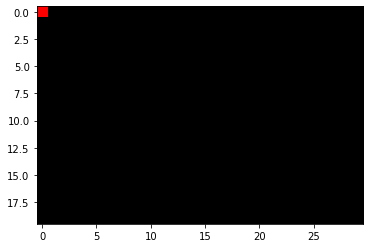

In [6]:
fin = final_im.view(20, 30, 3)

plt.imshow(fin.cpu().numpy())